# Spatial Analysis and Modeling

### Instructor: Rossano Schifanella

Email: [rossano.schifanella@unito.it](mailto:rossano.schifanella@unito.it)

This notebook has been edited from the tutorial **Spatial Data Science with PyData** presented at the [GeoPython 2018](http://2018.geopython.net/) conference by

- [Levi John Wolf](https://ljwolf.org) - [University of Bristol](http://www.bristol.ac.uk/geography/levi-j-wolf/overview.html)
- [Sergio Rey](https://sergerey.org/) - [Center for Geospatial Sciences, University of California, Riverside](http://spatial.ucr.edu/peopleRey.html)

In collaboration with:

- [Dani Arribas-Bel](http://darribas.org/) -  University of Liverpool
- [Wei Kang](http://spatial.ucr.edu/peopleKang.html)
- [Marynia Kolak](https://marynia.me)
- [Joris Van den Bossche](https://jorisvandenbossche.github.io/) - Ghent University 

## Spatial Autocorrelation 


In this notebook we introduce methods of _exploratory spatial data analysis_
that are intended to complement geovizualization through formal univariate and
multivariate statistical tests for spatial clustering.

In [101]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

In [102]:
import pandas as pd
import geopandas as gpd
import pysal as ps
import numpy as np

Our data set comes from the Berlin airbnb scrape taken in April 2018. This dataframe was constructed as part of the [GeoPython 2018 workshop](https://github.com/ljwolf/geopython) by [Levi Wolf](https://ljwolf.org) and [Serge Rey](https://sergerey.org). As part of the workshop a geopandas data frame was constructed with one of the columns reporting the median listing price of units in each neighborhood in Berlin:

In [103]:
df = gpd.read_file('../data/berlin-neighbourhoods/berlin-neighbourhoods.geojson')

In [104]:
df.head()

,neighbourh,neighbou_1,median_pri,geometry
0,Blankenfelde/Niederschönhausen,Pankow,37.5,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,58.0,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,50.0,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,99.0,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,25.0,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."


We have a `nan` to first deal with:

In [105]:
pd.isnull(df['median_pri']).sum()

1

In [106]:
df = df
df['median_pri'].fillna((df['median_pri'].mean()), inplace=True)


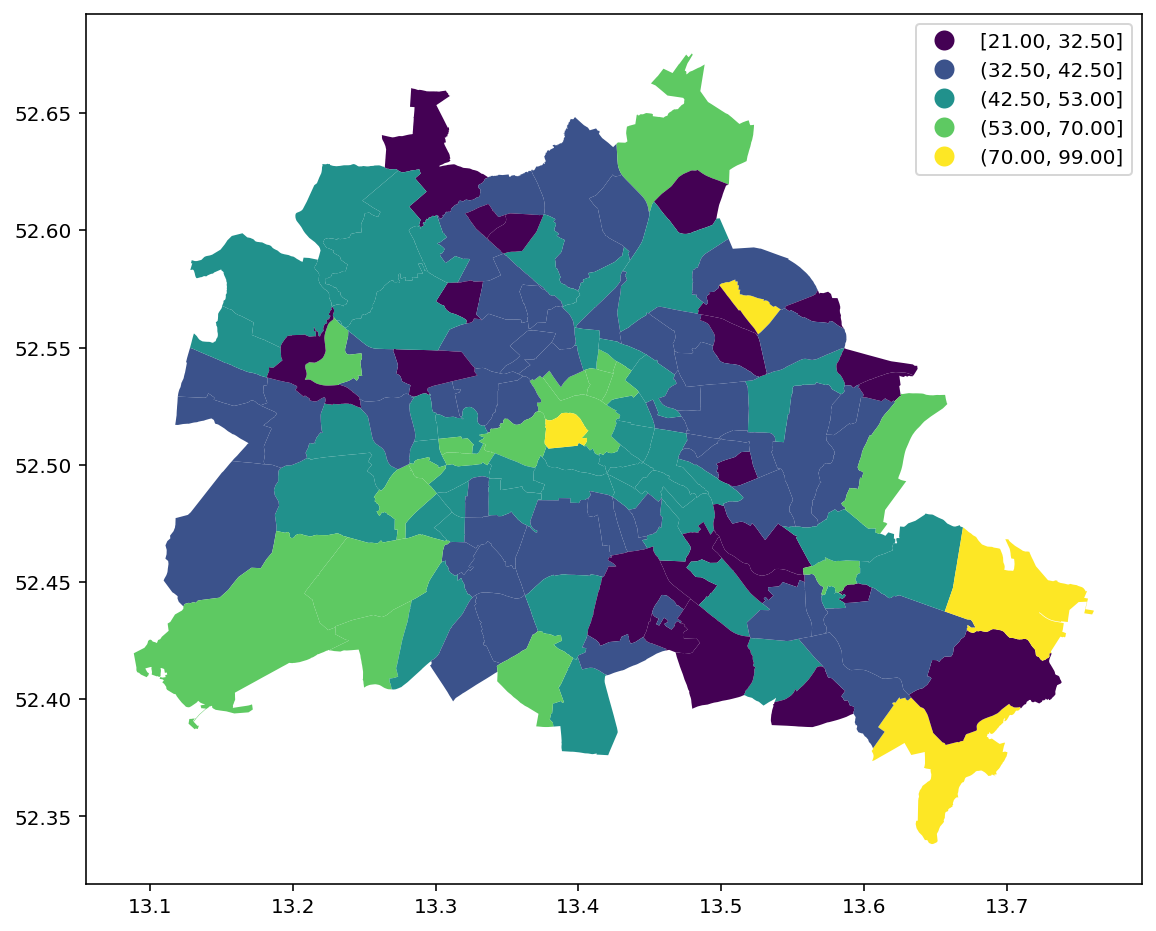

In [107]:
f, ax = plt.subplots(figsize=(12,8))
df.plot(column='median_pri', scheme='fisher_jenks', legend=True, ax=ax)

## Spatial Autocorrelation ##

Visual inspection of the map pattern for the prices allows us to search for
spatial structure. If the spatial distribution of the prices was random, then we
should not see any clustering of similar values on the map. However, our visual
system is drawn to the darker clusters in the south west as well as the center,
and a concentration of the lighter hues (lower prices) in the north central and
south east.

Our brains are very powerful pattern recognition machines. However, sometimes
they can be too powerful and lead us to detect false positives, or patterns
where there are no statistical patterns. This is a particular concern when
dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial
autocorrelation* relates to the combination of two types of similarity: spatial
similarity and attribute similarity. Although there are many different measures
of spatial autocorrelation, they all combine these two types of simmilarity into
a summary measure.

Let's use PySAL to generate these two types of similarity
measures.

### Spatial Similarity ###

We have already encountered spatial weights
in a previous notebook. In spatial autocorrelation analysis, the spatial weights
are used to formalize the notion of spatial similarity. As we have seen there
are many ways to define spatial weights, here we will use queen contiguity:

In [108]:
wq =  ps.lib.weights.Queen.from_dataframe(df)
wq.transform = 'r'

### Attribute Similarity ###

So the spatial weight between neighborhoods $i$ and $j$ indicates if the two 
are neighbors (i.e., geographically similar). What we also need is a measure of
attribute similarity to pair up with this concept of spatial similarity. The
**spatial lag** is a derived variable that accomplishes this for us. For neighborhood
$i$ the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

In [109]:
y = df['median_pri']
ylag = ps.lib.weights.lag_spatial(wq, y)

In [110]:
ylag

array([45.2       , 52.625     , 45.75      , 32.5       , 63.5       ,
       42.        , 45.625     , 44.14285714, 43.33333333, 38.75      ,
       41.5       , 50.8       , 36.6875    , 54.36363636, 54.375     ,
       38.92857143, 38.125     , 50.9       , 35.6875    , 59.66666667,
       46.875     , 46.92857143, 49.58333333, 47.25      , 53.25      ,
       40.57142857, 37.66666667, 37.14285714, 40.75      , 41.5       ,
       45.9       , 35.3       , 47.9375    , 47.33333333, 40.        ,
       44.        , 58.3       , 53.16666667, 41.1459854 , 43.75      ,
       51.625     , 52.3       , 50.5       , 46.91666667, 47.        ,
       38.125     , 35.33333333, 48.83333333, 46.6       , 43.125     ,
       39.95498783, 41.33333333, 42.        , 44.43248175, 55.66666667,
       46.2       , 47.33333333, 49.84124088, 47.93248175, 42.92857143,
       43.4       , 40.78571429, 37.42857143, 32.75      , 45.57142857,
       51.25      , 44.        , 33.33333333, 33.25      , 42.  

In [111]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

In [112]:
ylagq5.yb

array([3, 4, 3, 0, 4, 2, 3, 3, 2, 1, 2, 4, 0, 4, 4, 1, 0, 4, 0, 4, 3, 3,
       4, 3, 4, 1, 0, 0, 1, 2, 3, 0, 3, 3, 1, 2, 4, 4, 2, 2, 4, 4, 4, 3,
       3, 0, 0, 4, 3, 2, 1, 2, 2, 3, 4, 3, 3, 4, 3, 2, 2, 1, 0, 0, 3, 4,
       2, 0, 0, 2, 1, 0, 2, 2, 2, 1, 2, 3, 3, 4, 0, 1, 0, 3, 2, 0, 1, 2,
       1, 1, 1, 2, 1, 2, 1, 4, 4, 4, 0, 1, 4, 4, 4, 1, 2, 2, 0, 3, 1, 4,
       4, 3, 1, 3, 2, 3, 4, 3, 1, 1, 2, 3, 0, 1, 0, 0, 0, 1, 2, 1, 1, 0,
       0, 2, 0, 0, 0, 0])

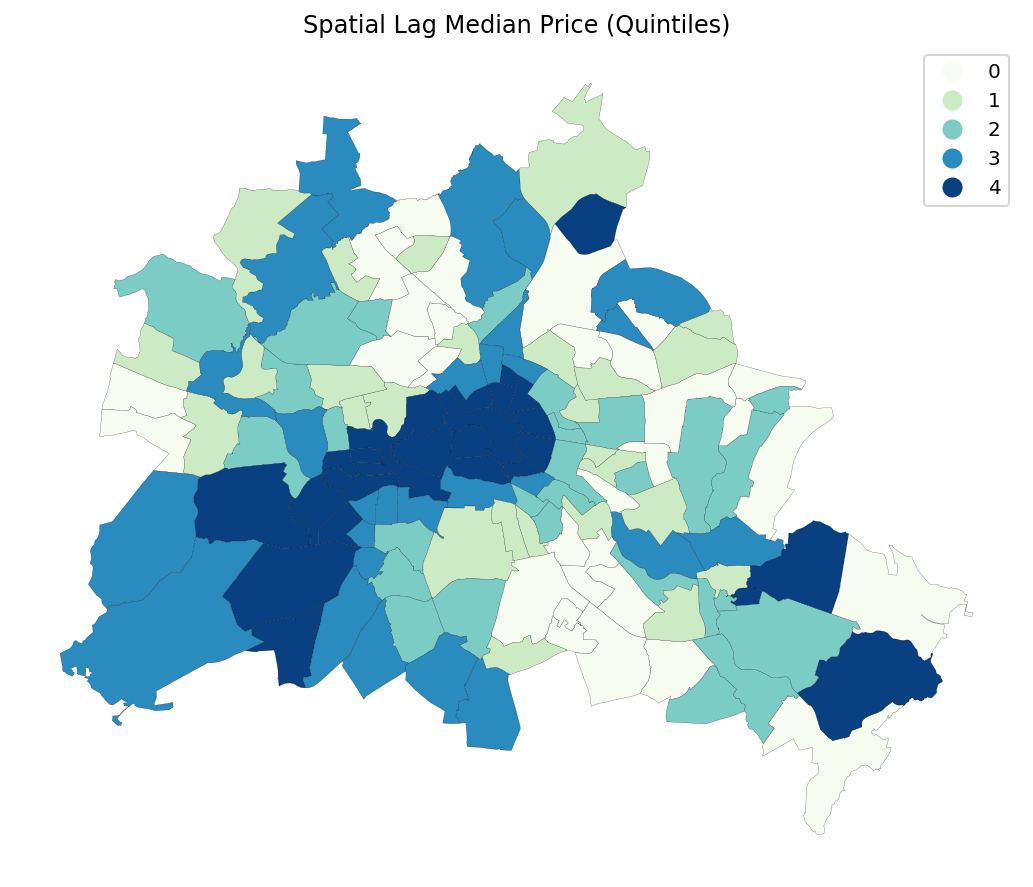

In [113]:
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Median Price (Quintiles)")

plt.show()

The quintile map for the spatial lag tends to enhance the impression of value
similarity in space. It is, in effect, a local smoother.

In [114]:
df['lag_median_pri'] = ylag

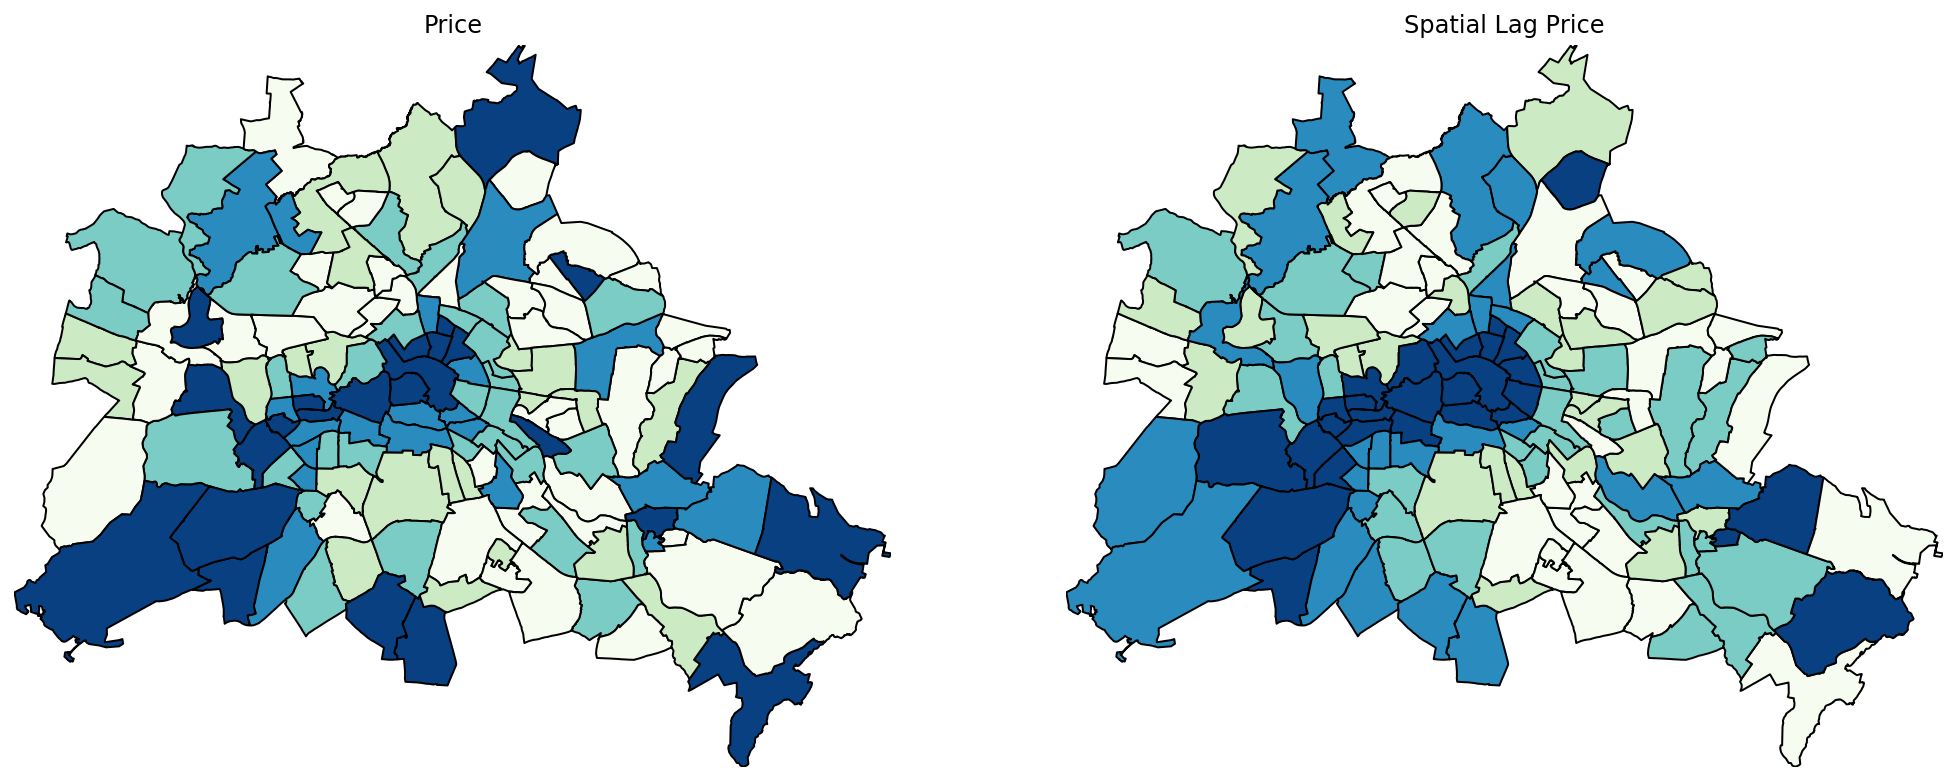

In [115]:
f,ax = plt.subplots(1,2,figsize=(2.16*8,8))

df.plot(column='median_pri', ax=ax[0], edgecolor='k',
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Price")


df.plot(column='lag_median_pri', ax=ax[1], edgecolor='k',
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(df.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Price")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

However, we still have
the challenge of visually associating the value of the prices in a neighborhod
with the value of the spatial lag of values for the focal unit. The latter is a
weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal
statistical measures of spatial autocorrelation.


## Global Spatial Autocorrelation

We begin with a simple case where the variable under consideration is binary.
This is useful to unpack the logic of spatial autocorrelation tests. So  even though
our attribute is a continuously valued one, we will convert it to a binary case
to illustrate the key concepts:

### Binary Case

In [116]:
y.median()

42.0

In [117]:
yb = y > y.median()
sum(yb)

68

We have 68 neighborhoods with list prices above the median and 70 below the
median (recall the issue with ties).

In [118]:
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
df['yb'] = yb

The spatial distribution of the binary variable immediately raises questions
about the juxtaposition of the "black" and "white" areas.

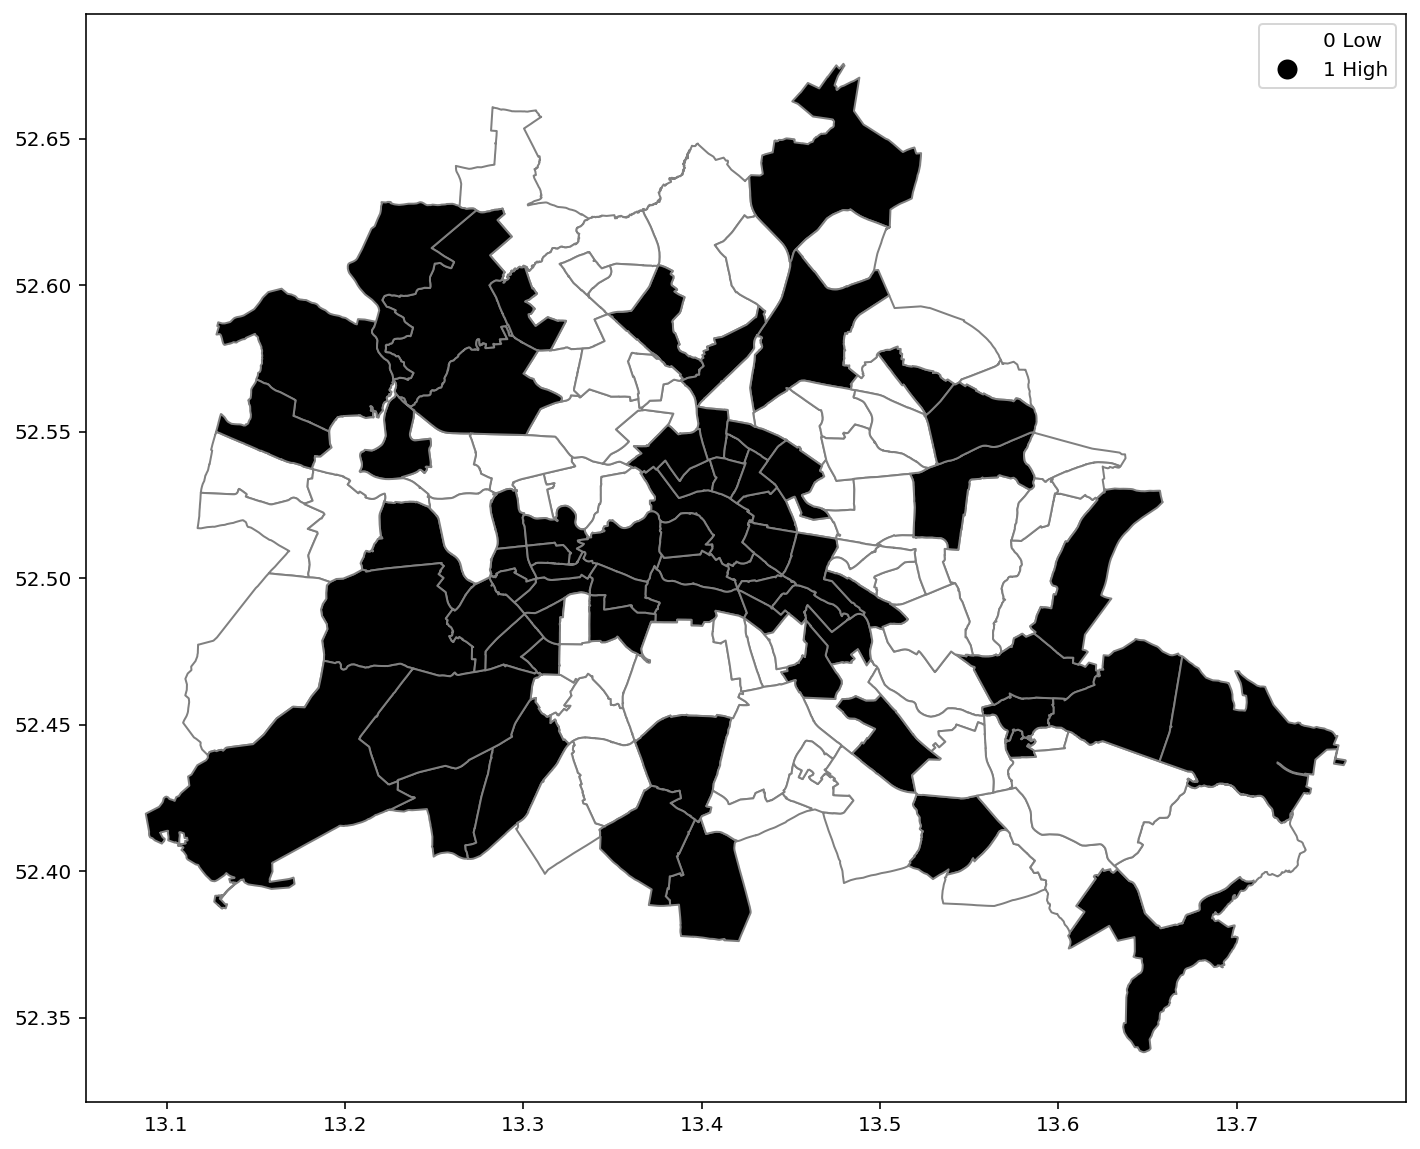

In [119]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

### Join counts ###

One way to formalize a test for spatial autocorrelation in a binary attribute is
to consider the so-called _joins_. A join exists for each neighbor pair of
observations, and the joins are reflected in our binary spatial weights object
`wq`. 

Each unit can take on one of two values "Black" or "White", and so for a given
pair of neighboring locations there are three different types of joins that can
arise:

- Black Black (BB)
- White White (WW)
- Black White (or White Black) (BW)

Given that we have 68 Black polygons on our map, what is the number of Black
Black (BB) joins we could expect if the process were such that the Black
polygons were randomly assigned on the map? This is the logic of join count statistics.

We can use the `esda` package from PySAL to carry out join count analysis:

In [120]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary
wq =  ps.lib.weights.Queen.from_dataframe(df)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

The resulting object stores the observed counts for the different types of joins:

In [121]:
jc.bb

121

In [122]:
jc.ww

114

In [123]:
jc.bw

150

Note that the three cases exhaust all possibilities:

In [124]:
jc.bb + jc.ww + jc.bw

385

and

In [125]:
wq.s0 / 2

385.0

which is the unique number of joins in the spatial weights object.

Our object tells us we have observed 121 BB joins:

In [126]:
jc.bb

121

The critical question for us, is whether this is a departure from what we would
expect if the process generating the spatial distribution of the Black polygons
were a completely random one? To answer this, PySAL uses random spatial
permutations of the observed attribute values to generate a realization under
the null of _complete spatial randomness_ (CSR). This is repeated a large number
of times (999 default) to construct a reference distribution to evaluate the
statistical significance of our observed counts.

The average number of BB joins from the synthetic realizations is:

In [127]:
jc.mean_bb

92

which is less than our observed count. The question is whether our observed
value is so different from the expectation that we would reject the null of CSR?

Text(0.5, 0, 'BB Counts')

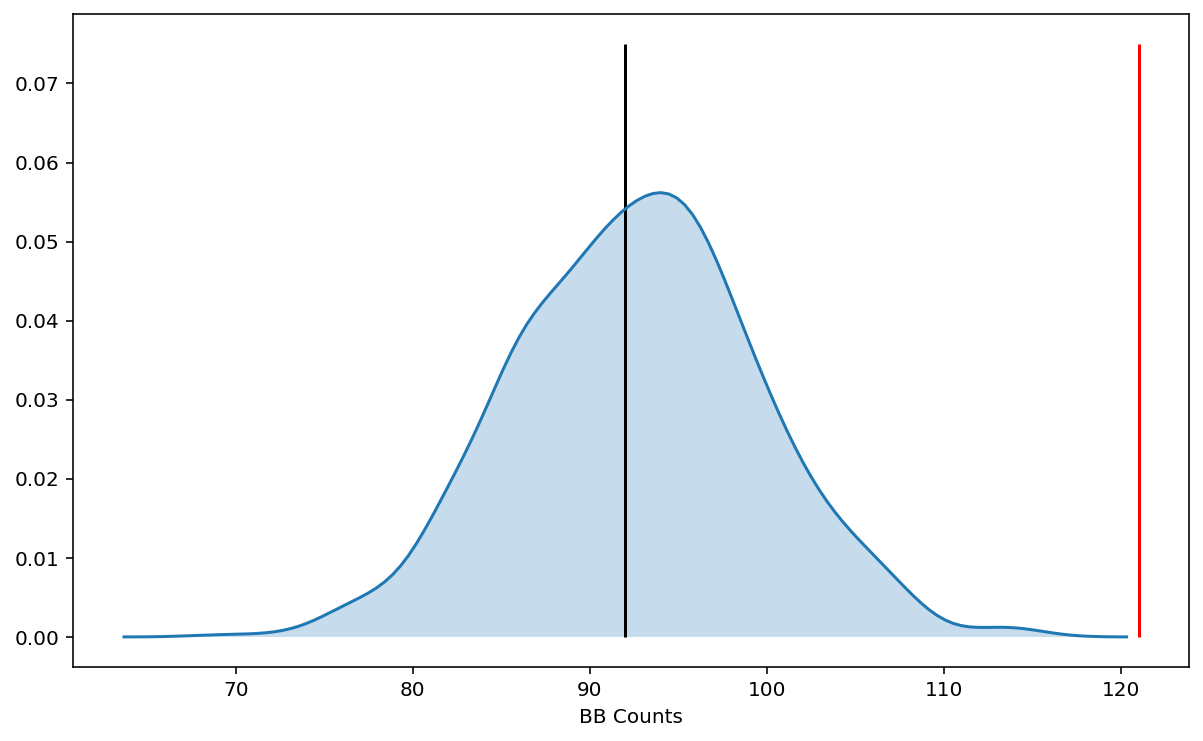

In [128]:
import seaborn as sbn

fig, ax = plt.subplots(figsize=(10,6))
sbn.kdeplot(jc.sim_bb, shade=True, ax = ax)
ax.vlines(jc.bb, 0, 0.075, color='r')
ax.vlines(jc.mean_bb, 0, 0.075)
ax.set_xlabel('BB Counts')

The density portrays the distribution of the BB counts, with the black vertical
line indicating the mean BB count from the synthetic realizations and the red
line the observed BB count for our prices. Clearly our observed value is
extremely high. A pseudo p-value summarizes this:

In [129]:
jc.p_sim_bb


0.001

Since this is below conventional significance levels, we would reject the null
of complete spatial randomness in favor of spatial autocorrelation in market prices.


### Continuous Case

The join count analysis is based on a binary attribute, which can cover many
interesting empirical applications where one is interested in presence and
absence type phenomena. In our case, we artificially created the binary variable,
and in the process we throw away a lot of information in our originally
continuous attribute. Turning back to the original variable, we can explore
other tests for spatial autocorrelation for the continuous case.

First, we transform our weights to be row-standardized, from the current binary state:

In [130]:
wq.transform = 'r'

In [131]:
y = df['median_pri']

Moran's I is a test for global autocorrelation for a continuous attribute:

In [132]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.09715984916381672

Again, our value for the statistic needs to be interpreted against a reference
distribution under the null of CSR. PySAL uses a similar approach as we saw in
the join count analysis: random spatial permutations.

Text(0.5, 0, "Moran's I")

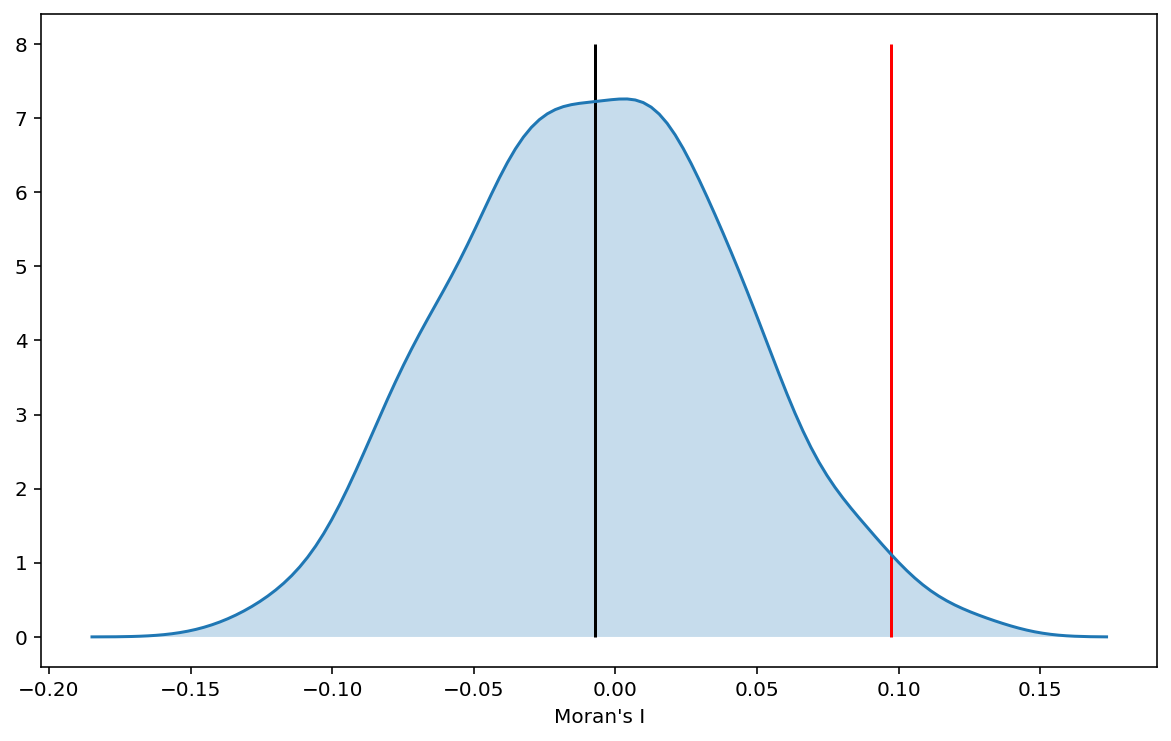

In [133]:
fig, ax = plt.subplots(figsize=(10,6))

sbn.kdeplot(mi.sim, shade=True, ax=ax)
ax.vlines(mi.I, 0, 8, color='r')
ax.vlines(mi.EI, 0, 8)
ax.set_xlabel("Moran's I")

Here our observed value is again in the upper tail, although visually it does
not look as extreme relative to the binary case. Yet, it is still statistically significant:

In [134]:
mi.p_sim

0.02

## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers ##

In addition to the Global autocorrelation statistics, PySAL has many local
autocorrelation statistics. Let's compute a local Moran statistic for the same
d

In [135]:
np.random.seed(12345)

In [136]:
wq.transform = 'r'
lag_price = ps.lib.weights.lag_spatial(wq, df['median_pri'])

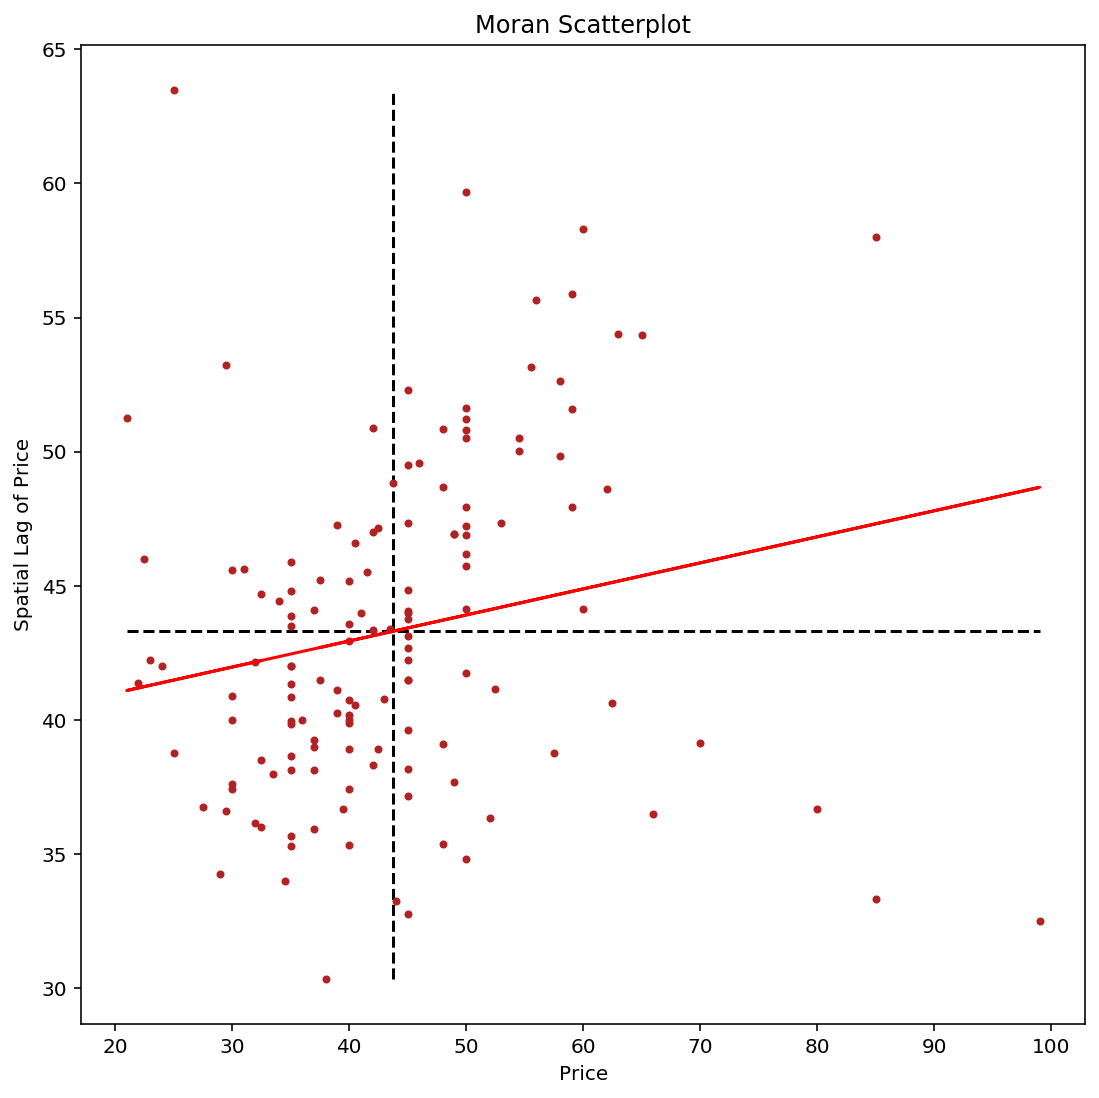

In [137]:
price = df['median_pri']
b, a = np.polyfit(price, lag_price, 1)

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(price, lag_price, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(price.mean(), lag_price.min(), lag_price.max(), linestyle='--')
 # dashed horizontal at mean of lagged price 
plt.hlines(lag_price.mean(), price.min(), price.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(price, a + b*price, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Price')
plt.xlabel('Price')
plt.show()


Now, instead of a single $I$ statistic, we have an *array* of local $I_i$
statistics, stored in the `.Is` attribute, and p-values from the simulation are
in `p_sim`.

In [138]:
li = esda.moran.Moran_Local(y, wq)

In [139]:
li.q

array([2, 1, 1, 4, 2, 3, 2, 1, 3, 4, 3, 1, 3, 1, 1, 3, 3, 2, 3, 1, 1, 1,
       1, 2, 2, 3, 4, 4, 3, 4, 2, 3, 1, 1, 3, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       2, 3, 3, 2, 2, 4, 3, 3, 3, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 4, 2, 2,
       2, 4, 4, 3, 3, 4, 3, 4, 2, 4, 4, 1, 2, 1, 4, 3, 4, 2, 3, 3, 3, 3,
       3, 3, 4, 3, 4, 3, 4, 1, 1, 1, 3, 3, 1, 1, 1, 3, 4, 1, 4, 2, 3, 1,
       1, 2, 4, 2, 2, 2, 1, 1, 3, 3, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 3, 3])

In [140]:
li.p_sim

array([0.376, 0.098, 0.302, 0.086, 0.005, 0.394, 0.316, 0.444, 0.5  ,
       0.194, 0.362, 0.105, 0.031, 0.004, 0.058, 0.149, 0.183, 0.09 ,
       0.019, 0.005, 0.216, 0.214, 0.118, 0.251, 0.14 , 0.27 , 0.048,
       0.077, 0.34 , 0.348, 0.333, 0.057, 0.155, 0.243, 0.214, 0.433,
       0.015, 0.043, 0.359, 0.462, 0.044, 0.077, 0.074, 0.247, 0.232,
       0.167, 0.094, 0.001, 0.279, 0.485, 0.236, 0.306, 0.416, 0.428,
       0.072, 0.29 , 0.263, 0.087, 0.229, 0.47 , 0.467, 0.266, 0.071,
       0.017, 0.32 , 0.097, 0.437, 0.04 , 0.019, 0.439, 0.254, 0.03 ,
       0.496, 0.396, 0.474, 0.148, 0.407, 0.206, 0.28 , 0.105, 0.142,
       0.272, 0.015, 0.373, 0.459, 0.078, 0.147, 0.257, 0.268, 0.122,
       0.25 , 0.47 , 0.207, 0.312, 0.358, 0.201, 0.13 , 0.065, 0.072,
       0.229, 0.079, 0.118, 0.137, 0.185, 0.337, 0.429, 0.046, 0.349,
       0.278, 0.01 , 0.039, 0.228, 0.227, 0.388, 0.415, 0.327, 0.089,
       0.387, 0.209, 0.265, 0.449, 0.428, 0.045, 0.223, 0.044, 0.006,
       0.028, 0.321,

We can again test for local clustering using permutations, but here we use
conditional random permutations (different distributions for each focal location)

In [141]:
(li.p_sim < 0.05).sum()

24

We can distinguish the specific type of local spatial association reflected in
the four quadrants of the Moran Scatterplot above:

In [142]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [143]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

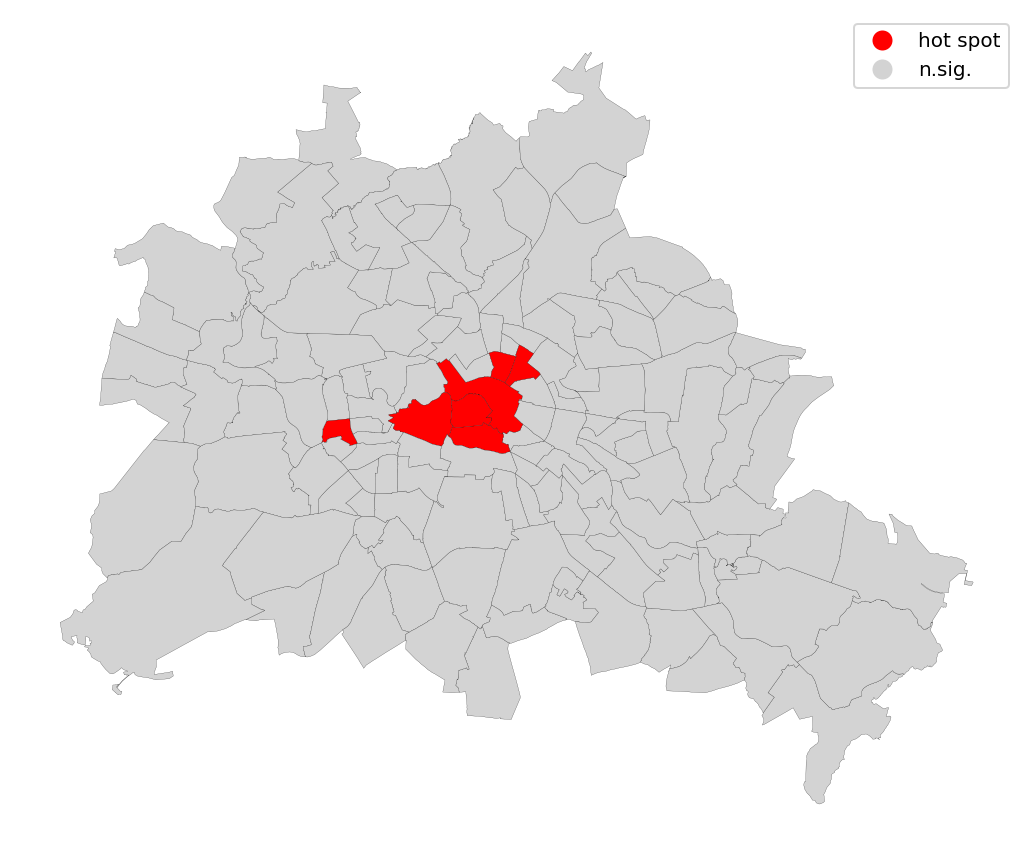

In [144]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

In [145]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

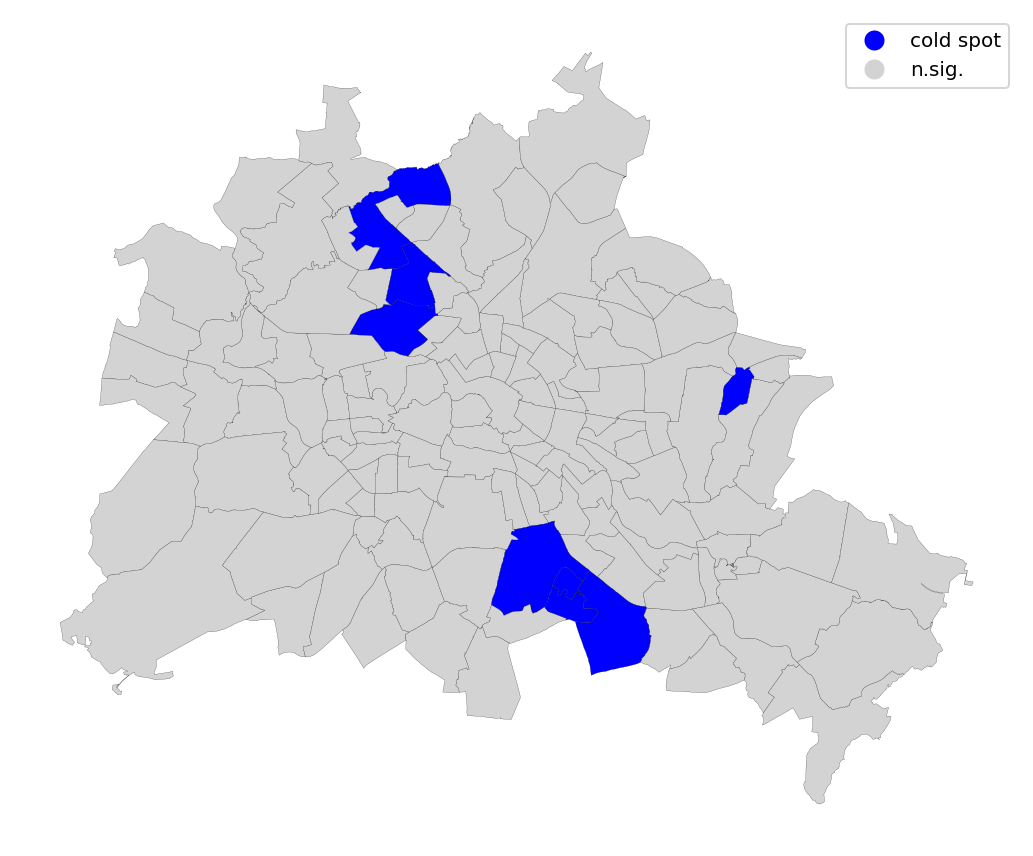

In [146]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

In [147]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

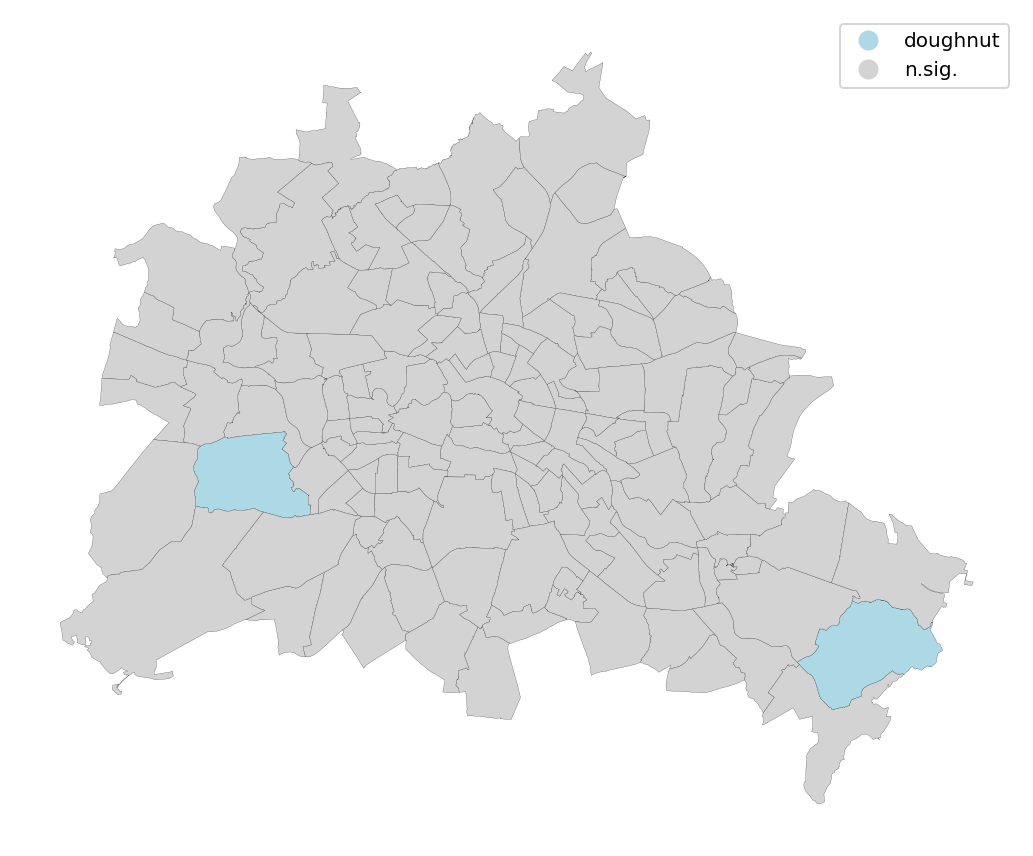

In [148]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

In [149]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

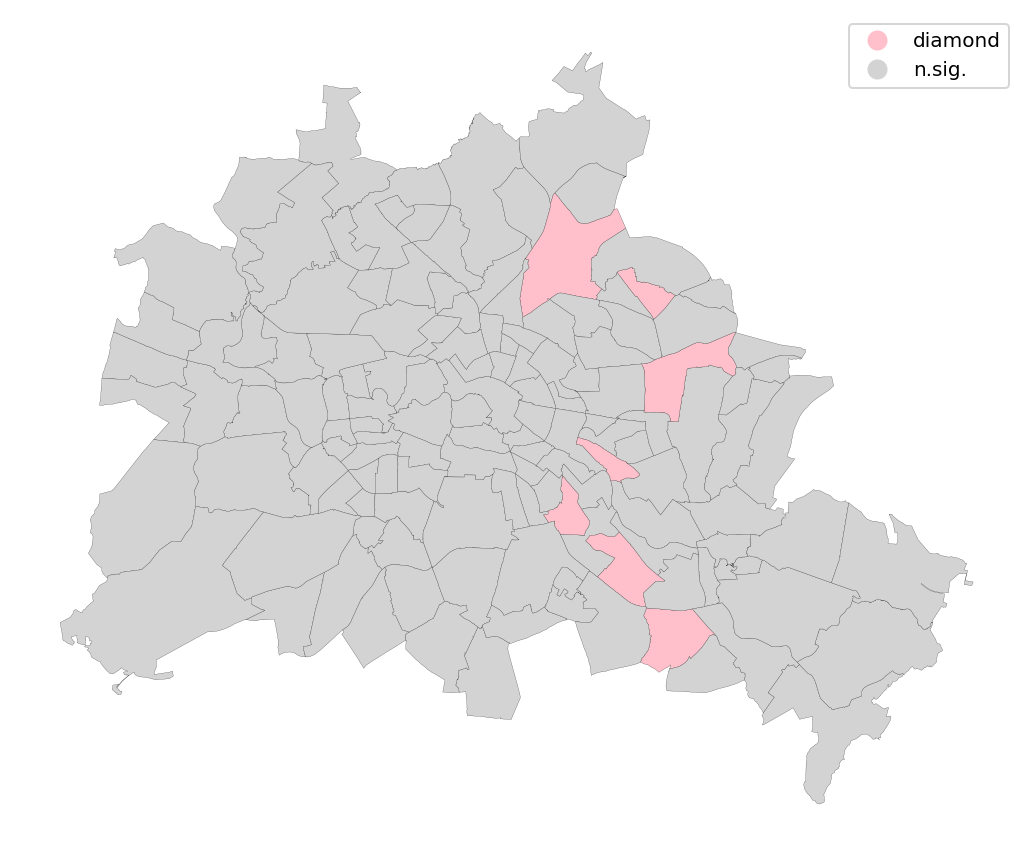

In [150]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

In [151]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 3, 1, 0, 0,
       0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       0, 4, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 3, 0])

In [152]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

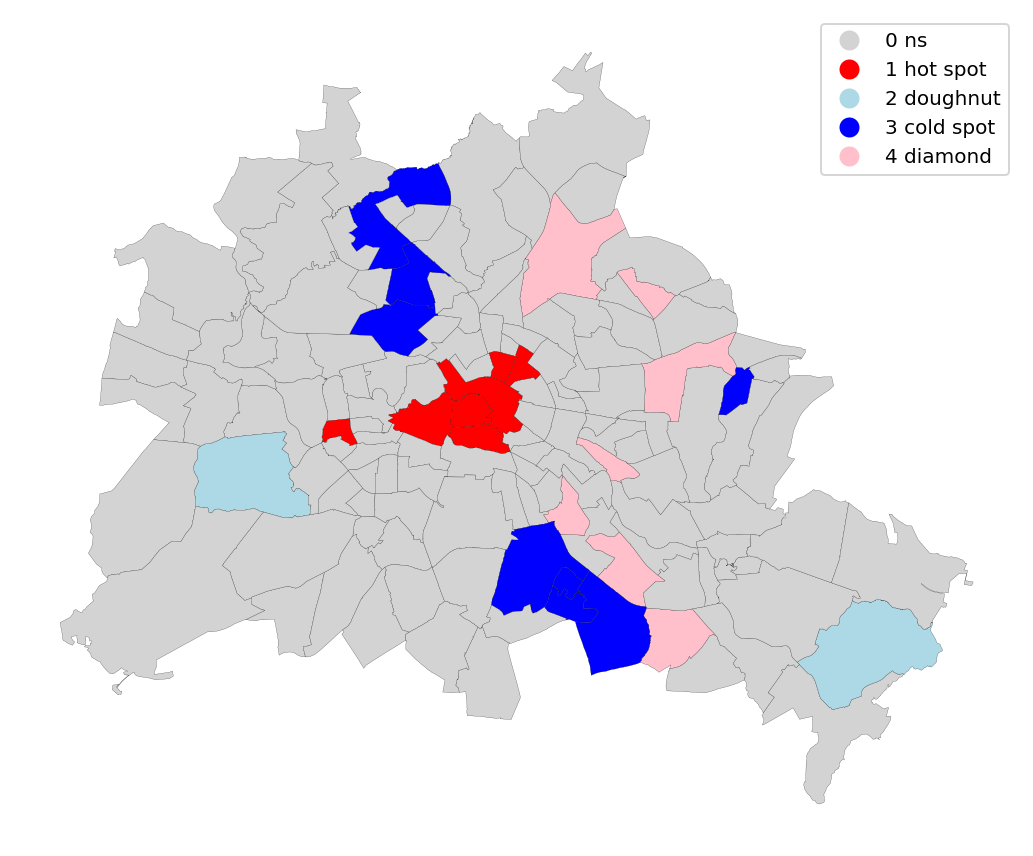

In [153]:

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

### Another example: the case of the homicide rate in Texas counties.

In [154]:
data = gpd.read_file("../data/texas/texas.shp")

In [155]:
data.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,Lipscomb,Texas,48,295,48295,48,295,48295,1,0.0,...,0.031817,0.286929,0.378219,0.407005,0.373005,6.724512,4.5,3.835360,6.093580,"POLYGON ((-100.00687 36.49388, -100.00114 36.4..."
1,Sherman,Texas,48,421,48421,48,421,48421,1,0.0,...,0.139958,0.288976,0.359377,0.415453,0.378041,5.665722,1.7,3.253796,3.869407,"POLYGON ((-102.16757 36.05463, -102.16522 36.4..."
2,Dallam,Texas,48,111,48111,48,111,48111,1,0.0,...,2.050906,0.331667,0.385996,0.370037,0.376015,7.546049,7.2,9.471366,14.231738,"POLYGON ((-102.16757 36.05463, -103.02356 36.0..."
3,Hansford,Texas,48,195,48195,48,195,48195,1,0.0,...,0.000000,0.253527,0.357813,0.393938,0.383924,7.591786,4.7,5.542986,7.125457,"POLYGON ((-101.61950 36.05471, -101.62032 36.4..."
4,Ochiltree,Texas,48,357,48357,48,357,48357,1,0.0,...,0.021911,0.236998,0.352940,0.343949,0.374461,5.172414,4.0,4.758392,9.159159,"POLYGON ((-101.08231 36.05626, -101.08967 36.4..."


In [156]:
data.columns.values

array(['NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS', 'FIPS', 'STFIPS',
       'COFIPS', 'FIPSNO', 'SOUTH', 'HR60', 'HR70', 'HR80', 'HR90',
       'HC60', 'HC70', 'HC80', 'HC90', 'PO60', 'PO70', 'PO80', 'PO90',
       'RD60', 'RD70', 'RD80', 'RD90', 'PS60', 'PS70', 'PS80', 'PS90',
       'UE60', 'UE70', 'UE80', 'UE90', 'DV60', 'DV70', 'DV80', 'DV90',
       'MA60', 'MA70', 'MA80', 'MA90', 'POL60', 'POL70', 'POL80', 'POL90',
       'DNL60', 'DNL70', 'DNL80', 'DNL90', 'MFIL59', 'MFIL69', 'MFIL79',
       'MFIL89', 'FP59', 'FP69', 'FP79', 'FP89', 'BLK60', 'BLK70',
       'BLK80', 'BLK90', 'GI59', 'GI69', 'GI79', 'GI89', 'FH60', 'FH70',
       'FH80', 'FH90', 'geometry'], dtype=object)

In [157]:
W = ps.lib.weights.Queen.from_shapefile("../data/texas/texas.shp")
W.transform = 'r'

### Attribute Similarity

So the spatial weight between counties $i$ and $j$ indicates if the two counties are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity.
The **spatial lag** is a derived variable that accomplishes this for us. For county $i$ the spatial lag is defined as:
$$HR90Lag_i = \sum_j w_{i,j} HR90_j$$



In [158]:
HR90Lag = ps.lib.weights.lag_spatial(W, data.HR90)

In [159]:
HR90LagQ10 = ps.viz.mapclassify.Quantiles(HR90Lag, k=10)

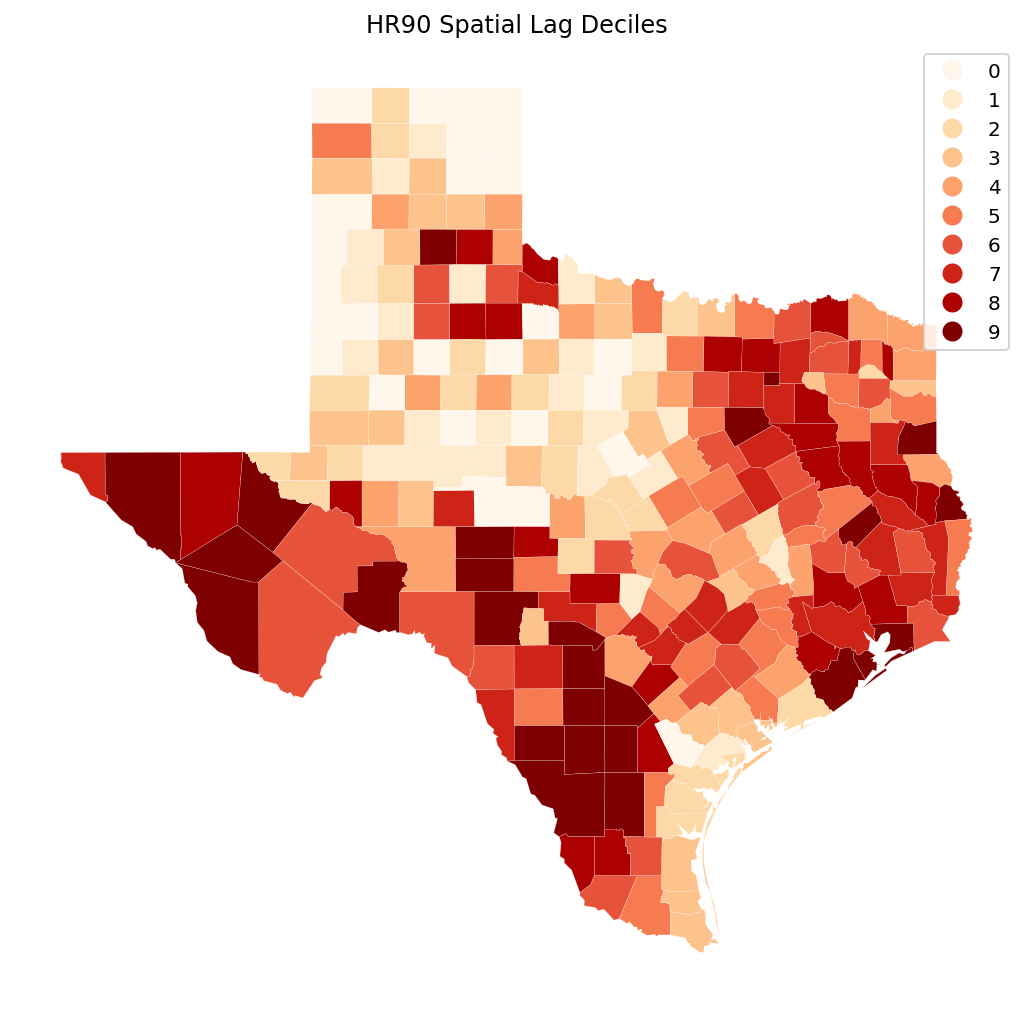

In [160]:
f, ax = plt.subplots(1, figsize=(9, 9))
data.assign(cl=HR90LagQ10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Spatial Lag Deciles")
plt.show()

The decile map for the spatial lag tends to enhance the impression of value similarity in space. However, we still have the challenge of visually associating the value of the homicide rate in a county with the value of the spatial lag of rates for the county. The latter is a weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal statistical measures of spatial autocorrelation.

In [161]:
HR90 = data.HR90
b,a = np.polyfit(HR90, HR90Lag, 1)

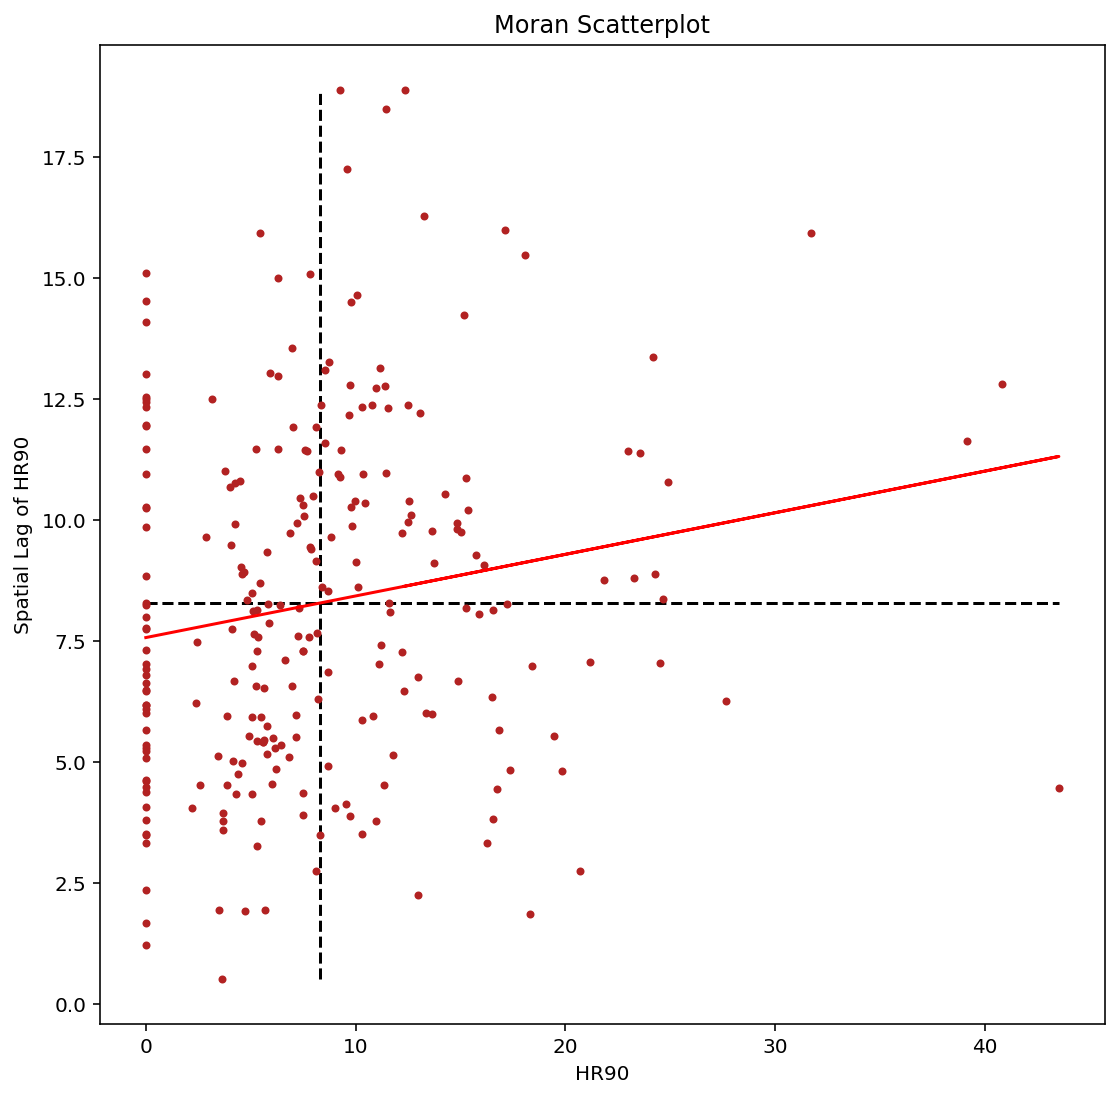

In [162]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(HR90, HR90Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), HR90Lag.min(), HR90Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(HR90Lag.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')
plt.show()

## Global Spatial Autocorrelation

In PySAL, commonly-used analysis methods are very easy to access. For example, if we were interested in examining the spatial dependence in `HR90` we could quickly compute a Moran's $I$ statistic:

In [163]:
I_HR90 = ps.explore.esda.Moran(data.HR90.values, W)

In [164]:
I_HR90.I, I_HR90.p_sim

(0.08597664031388977, 0.013)

Thus, the $I$ statistic is $0.859$ for this data, and has a small $p$ value. 

In [165]:
b # note I is same as the slope of the line in the scatterplot

0.0859766403138895

We can visualize the distribution of simulated $I$ statistics using the stored collection of simulated statistics:

In [166]:
I_HR90.sim[0:5]

array([-0.01403267,  0.01380925,  0.00921963,  0.0292126 , -0.0214484 ])

A simple way to visualize this distribution is to make a KDEplot (like we've done before), and add a rug showing all of the simulated points, and a vertical line denoting the observed value of the statistic:

(-0.15, 0.15)

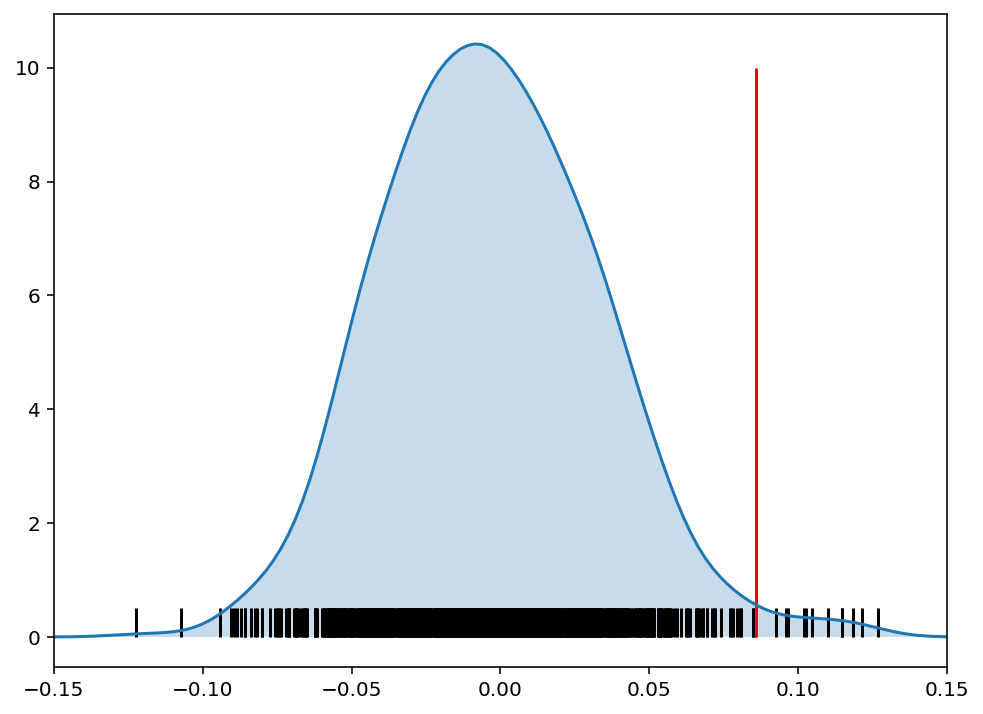

In [167]:
f, ax = plt.subplots(figsize=(8,6))

sns.kdeplot(I_HR90.sim, shade=True, ax=ax)
ax.vlines(I_HR90.sim, 0, 0.5)
ax.vlines(I_HR90.I, 0, 10, 'r')
ax.set_xlim([-0.15, 0.15])

Instead, if our $I$ statistic were close to our expected value, `I_HR90.EI`, our plot might look like this:

(-0.15, 0.15)

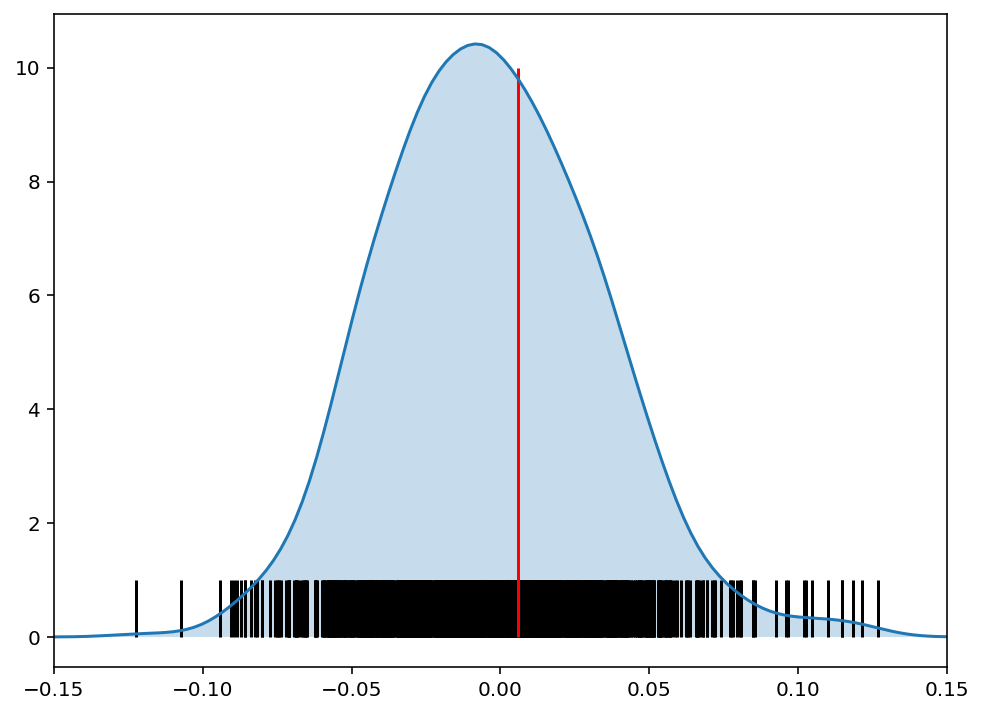

In [168]:
f, ax = plt.subplots(figsize=(8,6))

sns.kdeplot(I_HR90.sim, shade=True, ax=ax)
ax.vlines(I_HR90.sim, 0, 1)
ax.vlines(I_HR90.EI+.01, 0, 10, 'r')
ax.set_xlim([-0.15, 0.15])

The result of applying Moran's I is that we conclude the map pattern is not spatially random, but instead there is a signficant spatial association in homicide rates in Texas counties in 1990.

This result applies to the map as a whole, and is sometimes referred to as "global spatial autocorrelation". Next we turn to a local analysis where the attention shifts to detection of hot spots, cold spots and spatial outliers.

## Local Autocorrelation Statistics

In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics. Let's compute a local Moran statistic for the same data shown above:

In [169]:
LMo_HR90 = ps.explore.esda.Moran_Local(data.HR90.values, W)

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$ statistics, stored in the `.Is` attribute, and p-values from the simulation are in `p_sim`. 

In [170]:
LMo_HR90.Is[0:10], LMo_HR90.p_sim[0:10]

(array([ 1.12087323,  0.47485223, -1.22758423,  0.93868661,  0.68974296,
         0.78503173,  0.71047515,  0.41060686,  0.00740368,  0.14866352]),
 array([0.008, 0.182, 0.029, 0.015, 0.002, 0.012, 0.057, 0.057, 0.471,
        0.118]))

We can adjust the number of permutations used to derive every *pseudo*-$p$ value by passing a different `permutations` argument:

In [171]:
LMo_HR90 = ps.explore.esda.Moran_Local(data.HR90.values, W, permutations=9999)

In addition to the typical clustermap, a helpful visualization for LISA statistics is a Moran scatterplot with statistically significant LISA values highlighted. 

This is very simple, if we use the same strategy we used before:

First, construct the spatial lag of the covariate:

In [172]:
Lag_HR90 = ps.lib.weights.lag_spatial(W, data.HR90.values)
HR90 = data.HR90.values

Then, we want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way

In [173]:
sigs = HR90[LMo_HR90.p_sim <= .001]
W_sigs = Lag_HR90[LMo_HR90.p_sim <= .001]
insigs = HR90[LMo_HR90.p_sim > .001]
W_insigs = Lag_HR90[LMo_HR90.p_sim > .001]

Then, since we have a lot of points, we can plot the points with a statistically insignficant LISA value lighter using the `alpha` keyword. In addition, we would like to plot the statistically significant points in a dark red color. 

In [174]:
b,a = np.polyfit(HR90, Lag_HR90, 1)

Matplotlib has a list of [named colors](http://matplotlib.org/examples/color/named_colors.html) and will interpret colors that are provided in hexadecimal strings:

Text(0.5, 0, 'HR90')

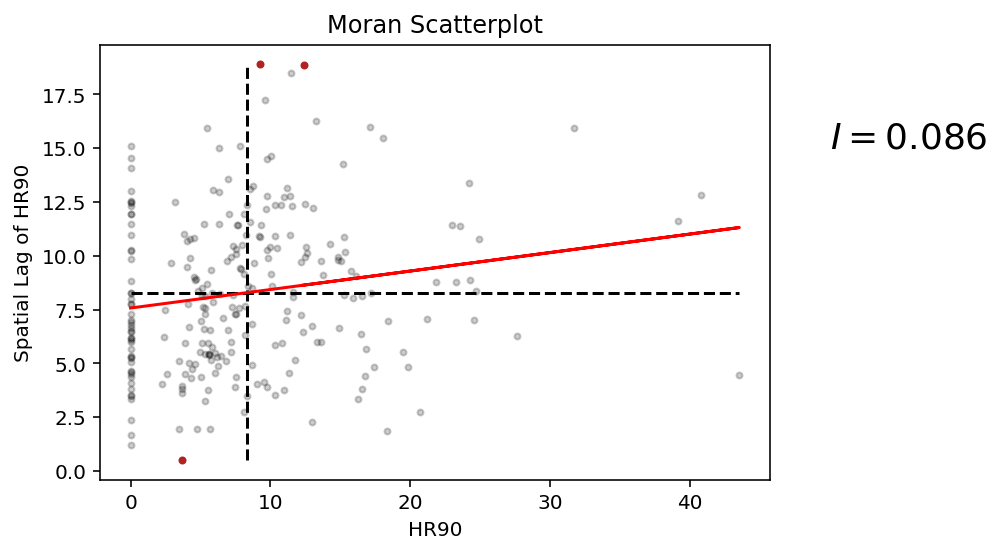

In [175]:
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), Lag_HR90.min(), Lag_HR90.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Lag_HR90.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.text(s='$I = %.3f$' % I_HR90.I, x=50, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')

We can also make a LISA map of the data. 

In [176]:
sig = LMo_HR90.p_sim < 0.05

In [177]:
sig.sum()

43

In [178]:
hotspots = LMo_HR90.q==1 * sig

In [179]:
hotspots.sum()

9

In [180]:
coldspots = LMo_HR90.q==3 * sig

In [181]:
coldspots.sum()

18

In [182]:
data.HR90[hotspots]

98      9.784698
132    11.435106
164    17.129154
209    13.274924
229    12.371338
234    31.721863
236     9.584971
239     9.256549
242    18.062652
Name: HR90, dtype: float64

In [183]:
data[hotspots]

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
98,Ellis,Texas,48,139,48139,48,139,48139,1,9.217652,...,10.009746,0.325785,0.365177,0.352516,0.372783,12.418831,10.5,9.076165,12.031635,"POLYGON ((-97.08502 32.27568, -97.08943 32.556..."
132,Hudspeth,Texas,48,229,48229,48,229,48229,1,9.971084,...,0.514580,0.312484,0.373474,0.440944,0.476631,14.115899,7.7,8.959538,11.363636,"POLYGON ((-104.98693 30.64132, -104.99754 30.6..."
164,Jeff Davis,Texas,48,243,48243,48,243,48243,1,0.000000,...,0.359712,0.316019,0.367719,0.437014,0.399655,14.438503,10.1,5.970149,8.255159,"POLYGON ((-104.98693 30.64132, -104.91489 30.6..."
209,Chambers,Texas,48,071,48071,48,71,48071,1,3.211613,...,12.694146,0.299847,0.374105,0.378431,0.364723,9.462037,9.2,8.568120,10.598911,"POLYGON ((-94.37701 29.55197, -94.38441 29.600..."
229,Frio,Texas,48,163,48163,48,163,48163,1,3.296414,...,1.358373,0.390980,0.463020,0.435098,0.473507,14.665445,9.4,11.842919,18.330362,"POLYGON ((-98.80789 28.63899, -99.39335 28.636..."
234,La Salle,Texas,48,283,48283,48,283,48283,1,0.000000,...,1.008755,0.421556,0.482174,0.489173,0.492687,18.167702,14.1,13.052937,20.088626,"POLYGON ((-98.80675 28.06071, -99.38992 28.035..."
236,Dimmit,Texas,48,127,48127,48,127,48127,1,0.000000,...,0.575098,0.417976,0.452789,0.456840,0.479503,13.826043,10.1,10.944363,17.769080,"POLYGON ((-99.39232 28.20364, -100.11039 28.20..."
239,Webb,Texas,48,479,48479,48,479,48479,1,2.057899,...,0.117083,0.382594,0.443082,0.439100,0.461075,20.292824,15.5,17.419676,20.521271,"POLYGON ((-98.95807 27.27069, -99.33515 27.270..."
242,Duval,Texas,48,131,48131,48,131,48131,1,2.487934,...,0.092894,0.370217,0.427660,0.421041,0.458937,15.829478,13.2,12.803677,20.699881,"POLYGON ((-98.53449 27.27302, -98.53728 27.348..."


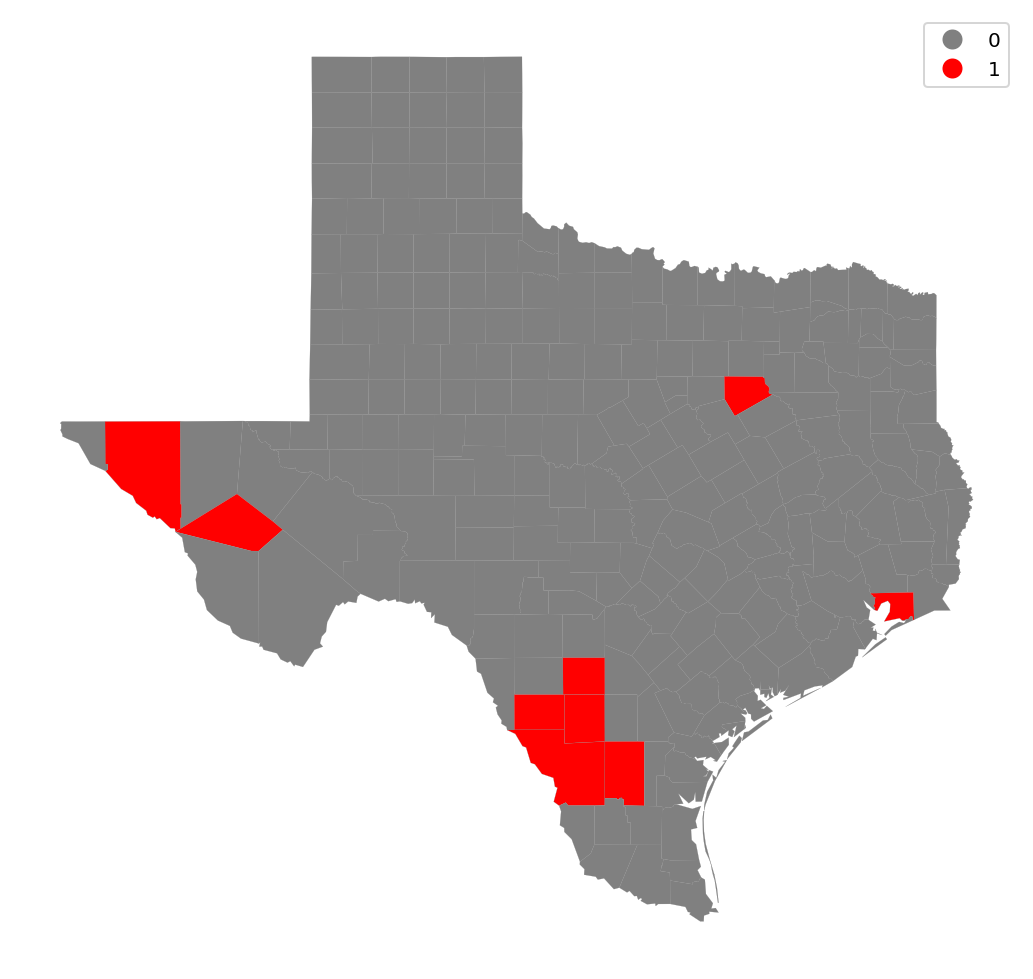

In [184]:
from matplotlib import colors
hmap = colors.ListedColormap(['grey', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
data.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

In [185]:
data.HR90[coldspots]

0      0.000000
3      0.000000
4      3.651767
5      0.000000
13     5.669899
19     3.480743
21     3.675119
32     2.211607
33     4.718762
48     5.509870
51     0.000000
62     3.677958
68     5.043627
69     0.000000
81     0.000000
87     3.699593
140    8.125292
233    5.304688
Name: HR90, dtype: float64

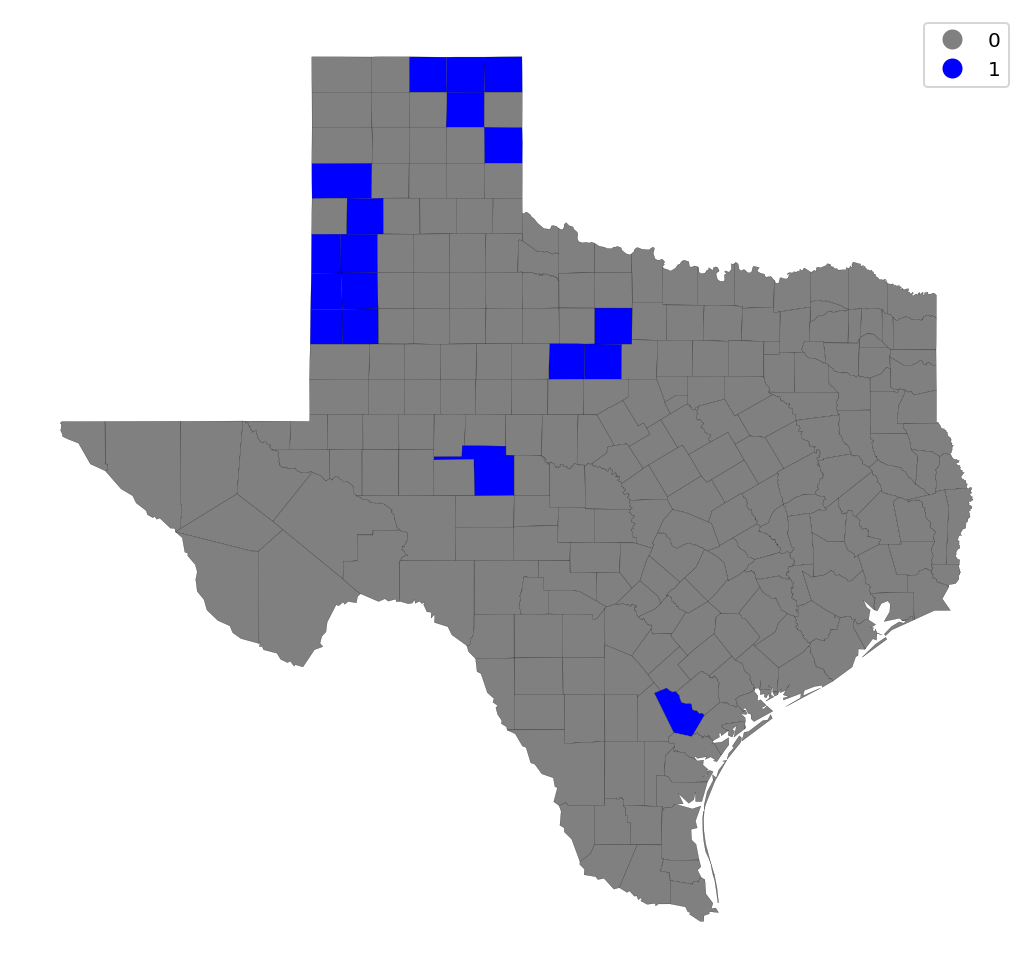

In [186]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
data.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()


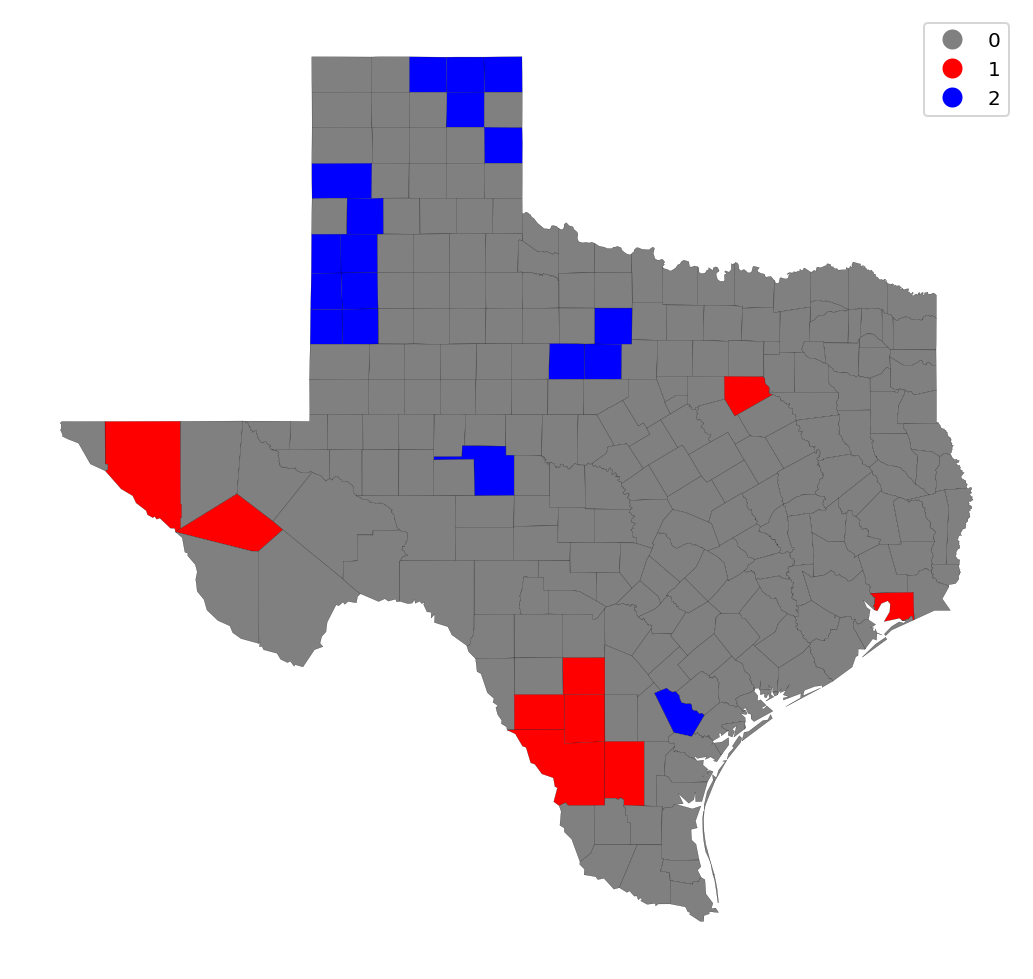

In [187]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9, 9))
data.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

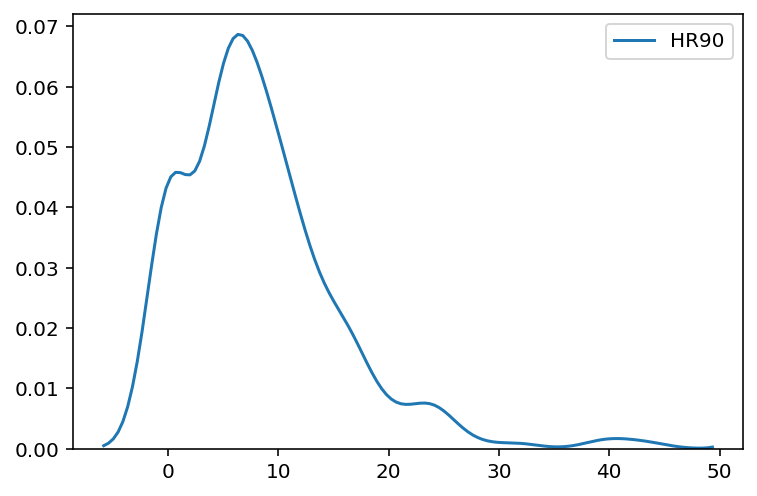

In [188]:
sns.kdeplot(data.HR90)

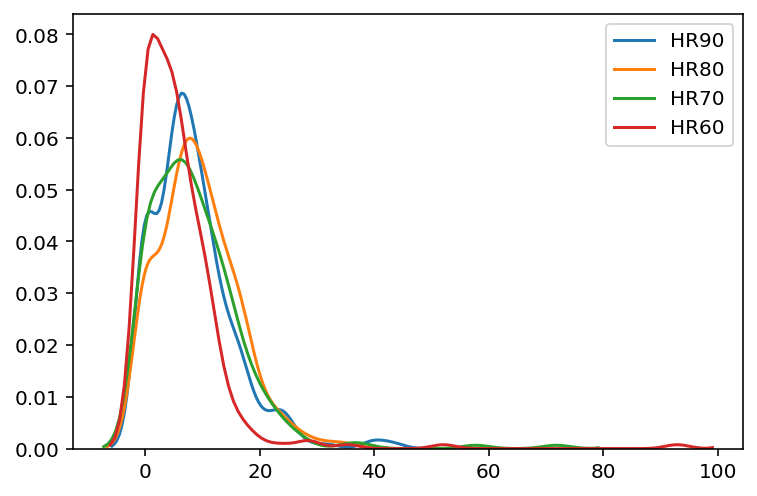

In [189]:
sns.kdeplot(data.HR90)
sns.kdeplot(data.HR80)
sns.kdeplot(data.HR70)
sns.kdeplot(data.HR60)

In [190]:
data.HR90.mean()

8.302494460285038

In [191]:
data.HR90.median()

7.23234613355